In [31]:
import os
import json
import hashlib
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# configuración inicial, paths y carga de archivos
data_path = '../data' 
excel_files = sorted(glob.glob(os.path.join(data_path, 'Totalizadores*.xlsx')))

if not excel_files:
    print(f"No se encontraron archivos .xlsx en la carpeta: {data_path}")
else:
    print(f"Se encontraron {len(excel_files)} Archivos Excel encontrados y ordenados.")
    print([os.path.basename(f) for f in excel_files])

sheets_to_load = ['Consolidado EE', 'Consolidado Produccion', 'Consolidado GasVapor', 'Consolidado Agua']
timestamp_col_name = None
unified_sheets = {}


Archivos Excel encontrados y ordenados: 3
['Totalizadores Planta - 2021_2023.xlsx', 'Totalizadores Planta 2020_2022.xlsx', 'Totalizadores Planta 2022_2023.xlsx']


In [33]:
# función que usamos para cargar y unificar las hojas de los archivos Excel, y eliminar duplicados
def load_and_unify_sheet(sheet_name, files):
    global timestamp_col_name
    data_frames = []
    print(f"Procesando hoja: '{sheet_name}'")
    
    for file in files:
        try:
            df_sheet = pd.read_excel(file, sheet_name=sheet_name)
            if timestamp_col_name is None:
                timestamp_col_name = df_sheet.columns[0]
                print(f"  > Columna de Timestamp: '{timestamp_col_name}'")
            data_frames.append(df_sheet)
        except Exception as e:
            print(f"  > Error al leer '{sheet_name}' de {os.path.basename(file)}: {e}")

    if data_frames:
        full_df = pd.concat(data_frames, ignore_index=True)
        # aca hacemos la limpieza de timestamps y eliminamos duplicados
        full_df[timestamp_col_name] = pd.to_datetime(full_df[timestamp_col_name], errors='coerce')
        full_df = full_df.dropna(subset=[timestamp_col_name])
        full_df = full_df.sort_values(by=timestamp_col_name)
        full_df = full_df.drop_duplicates(subset=[timestamp_col_name], keep='last')
        
        print(f"  > Hoja unificada. Filas horarias (sin duplicados): {full_df.shape[0]}")
        return full_df
    return pd.DataFrame()

In [ ]:
# carga y unificación de las hojas necesarias
if excel_files:
    # cargamos las hojas necesarias
    for sheet in sheets_to_load:
        unified_sheets[sheet] = load_and_unify_sheet(sheet, excel_files)

    # nos aseguramos de que la hoja principal (EE) exista
    if 'Consolidado EE' not in unified_sheets or unified_sheets['Consolidado EE'].empty:
        print("\nNo se pudo cargar 'Consolidado EE'")
    else:
        # renombrar timestamp para el merge
        df_hourly_merged = unified_sheets['Consolidado EE'].rename(columns={timestamp_col_name: 'Timestamp'})
        
        # itermaos y unimos las otras hojas
        for sheet_name in sheets_to_load:
            if sheet_name == 'Consolidado EE':
                continue # Ya la tenemos
            
            if sheet_name in unified_sheets and not unified_sheets[sheet_name].empty:
                df_to_merge = unified_sheets[sheet_name].rename(columns={timestamp_col_name: 'Timestamp'})
                
                # renombramos las columnas para evitar conflictos
                suffix = f"_{sheet_name.split(' ')[-1]}" 
                
                merge_cols = {col: f"{col}{suffix}" for col in df_to_merge.columns if col != 'Timestamp'}
                df_to_merge = df_to_merge.rename(columns=merge_cols)
                
                # unimos
                df_hourly_merged = pd.merge(df_hourly_merged, df_to_merge, on='Timestamp', how='outer')
                print(f"\nMerge con '{sheet_name}' completado.")

        # calculamos el total diario filtrando la última hora del día
        df_hourly_merged = df_hourly_merged.sort_values(by='Timestamp')
        df_hourly_merged['fecha_dia'] = df_hourly_merged['Timestamp'].dt.date
        idx_last_hour = df_hourly_merged.groupby('fecha_dia')['Timestamp'].idxmax()
        
        df_daily_final = df_hourly_merged.loc[idx_last_hour].copy()
        
        # ordenamos el índice por fecha
        df_daily_final = df_daily_final.set_index(pd.to_datetime(df_daily_final['fecha_dia']))
        df_daily_final = df_daily_final.sort_index() 
        
        columns_to_drop = [col for col in ['Timestamp', 'fecha_dia', timestamp_col_name] if col in df_daily_final.columns]
        df_daily_final = df_daily_final.drop(columns=columns_to_drop)

        print(f"\nDataFrame DIARIO 'df_daily_final' creado en memoria.")
        print(f"Dimensiones : {df_daily_final.shape}")
        print("\nPrimeras 5 filas:")
        print(df_daily_final.head())
else:
    print("No se encontraron archivos Excel para procesar.")

Procesando hoja: 'Consolidado EE'
  > Columna de Timestamp: 'DIA'
  > Hoja unificada. Filas horarias (sin duplicados): 1190
Procesando hoja: 'Consolidado Produccion'
  > Hoja unificada. Filas horarias (sin duplicados): 1190
Procesando hoja: 'Consolidado GasVapor'
  > Hoja unificada. Filas horarias (sin duplicados): 1190
Procesando hoja: 'Consolidado Agua'
  > Hoja unificada. Filas horarias (sin duplicados): 1190

Merge con 'Consolidado Produccion' completado.

Merge con 'Consolidado GasVapor' completado.

Merge con 'Consolidado Agua' completado.

DataFrame DIARIO 'df_daily_final' creado en memoria.
Dimensiones : (1190, 80)

Primeras 5 filas:
                HORA  Planta (Kw)  Elaboracion (Kw)  Bodega (Kw)  Cocina (Kw)  \
fecha_dia                                                                       
2020-07-01  07:00:00      6875.62            649.25       827.75         26.0   
2020-07-02  06:00:00     13694.37            912.75      1067.50         95.0   
2020-07-03  06:00:00     1

In [ ]:
# creamción del archivo CSV con el DataFrame diario unificado

# Definir rutas
daily_csv_path = os.path.join(data_path, 'df_daily_unified.csv')

if 'df_daily_final' in locals() and not df_daily_final.empty:
    # guardar el DataFrame diario unificado 
    df_daily_final.to_csv(daily_csv_path, index=True)
    print(f"DataFrame diario guardado exitosamente en: {daily_csv_path}")
else:
    print(f"El DataFrame 'df_daily_final' no existe o está vacío.")

DataFrame diario guardado exitosamente en: ../data\df_daily_unified.csv


In [ ]:
# checksum del DataFrame diario unificado
checksum_file_path = os.path.join(data_path, 'checksums.json')

try:
    # Calcular el hash MD5 del archivo [cite: 68]
    with open(daily_csv_path, 'rb') as f:
        file_bytes = f.read()
        md5_hash = hashlib.md5(file_bytes).hexdigest()

    checksum_data = {
        "df_daily_unified": {
            "file": daily_csv_path,
            "hash_md5": md5_hash,
            "timestamp": pd.Timestamp.now().isoformat()
        }
    }
    
    # Guardar el JSON [cite: 69, 237]
    with open(checksum_file_path, 'w') as f:
        json.dump(checksum_data, f, indent=4)

    print(f"-Checksum")
    print(f"Hash MD5 del DataFrame diario: {md5_hash}")
    print(f"Checksum guardado en: {checksum_file_path}")

except FileNotFoundError:
    print(f"No se encontró el archivo {daily_csv_path}.")

-Checksum
Hash MD5 del DataFrame diario: 4422333d485a8dfd5ad6e89bd242f8e4
Checksum guardado en: ../data\checksums.json


### Análisis Temporal

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

sns.set_theme(style="whitegrid")
# creamos un DataFrame temporal para los gráficos
if 'df_daily_final' in locals() and not df_daily_final.empty:
    df_plot = df_daily_final.copy()

    # cramos variables temporales desde el índice
    df_plot['año'] = df_plot.index.year
    df_plot['mes_num'] = df_plot.index.month
    df_plot['mes_nombre'] = df_plot.index.month_name()
    df_plot['dia_semana'] = df_plot.index.day_name()

    # ordenamos los días de la semana y meses para los gráficos
    week_days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    df_plot['dia_semana'] = pd.Categorical(df_plot['dia_semana'], categories=week_days_order, ordered=True)

    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    df_plot['mes_nombre'] = pd.Categorical(df_plot['mes_nombre'], categories=month_order, ordered=True)

    print("Variables 'año', 'mes_nombre' y 'dia_semana' creadas para graficar.")
    print(df_plot[['Frio (Kw)', 'año', 'mes_nombre', 'dia_semana']].head())
else:
    print("El DataFrame 'df_daily_final' no se encontró.")

Variables 'año', 'mes_nombre' y 'dia_semana' creadas para graficar.
            Frio (Kw)   año mes_nombre dia_semana
fecha_dia                                        
2020-07-01     3545.0  2020       July  Wednesday
2020-07-02     4998.0  2020       July   Thursday
2020-07-03     6378.0  2020       July     Friday
2020-07-04     4602.0  2020       July   Saturday
2020-07-05     4914.0  2020       July     Sunday


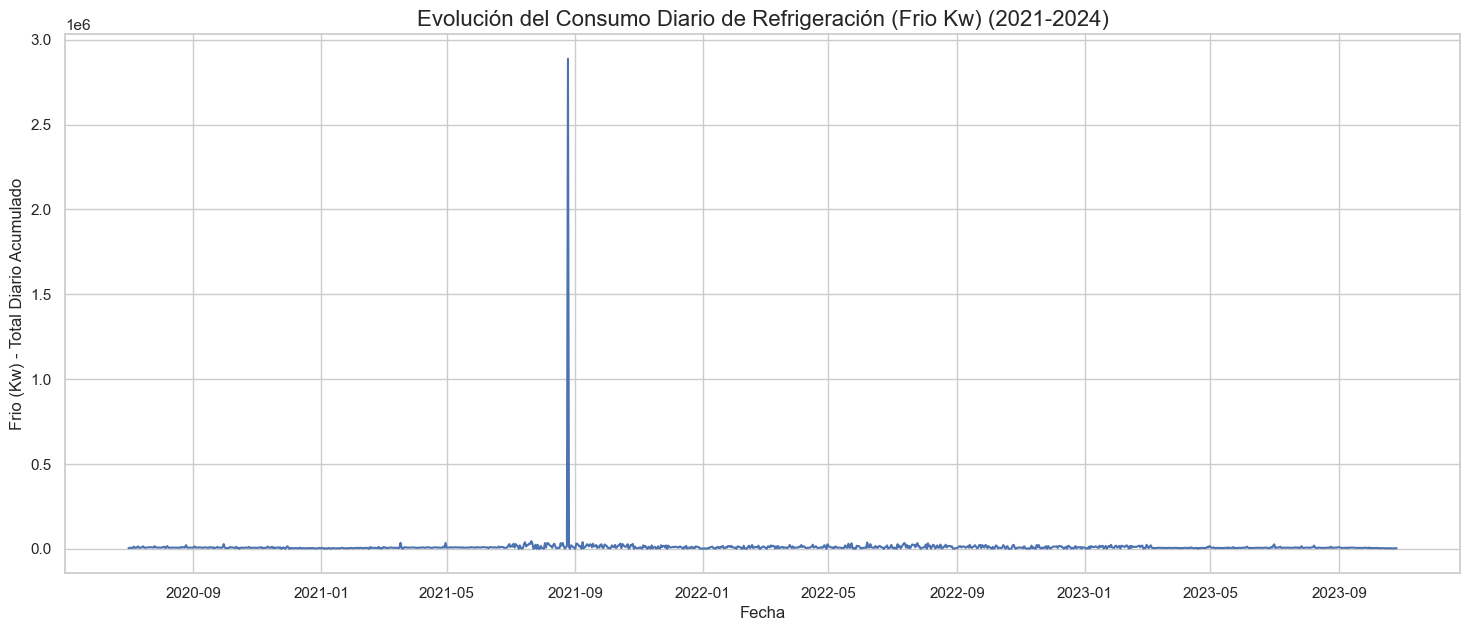

In [ ]:
# Gráfico de la evolución temporal de 'Frio (Kw)'
if 'df_plot' in locals():
    plt.figure(figsize=(18, 7)) 

    # Graficamos 'Frio (Kw)' contra el índice (la fecha)
    sns.lineplot(data=df_plot, x=df_plot.index, y='Frio (Kw)')

    plt.title('Evolución del Consumo Diario de Refrigeración (Frio Kw) (2021-2024)', fontsize=16)
    plt.xlabel('Fecha')
    plt.ylabel('Frio (Kw) - Total Diario Acumulado')
    plt.show() 
else:
    print("El DataFrame 'df_plot' no existe. Ejecuta el Bloque 7 primero.")

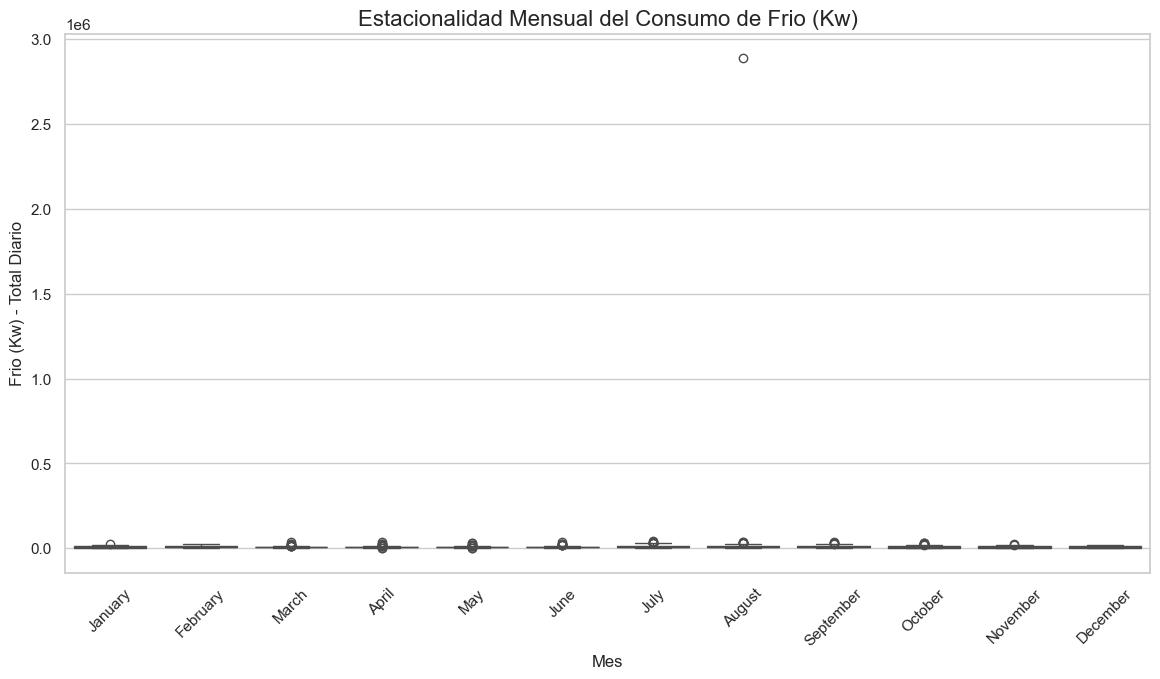

In [ ]:
# Gráfico Boxplot Mensual de Estacionalidad de 'Frio (Kw)'

if 'df_plot' in locals():
    plt.figure(figsize=(14, 7))

    # boxplot de Frio (Kw) agrupado por mes
    sns.boxplot(data=df_plot, x='mes_nombre', y='Frio (Kw)')

    plt.title('Estacionalidad Mensual del Consumo de Frio (Kw)', fontsize=16)
    plt.xlabel('Mes')
    plt.ylabel('Frio (Kw) - Total Diario')
    plt.xticks(rotation=45) # Rotamos las etiquetas de los meses
    plt.show()
else:
    print("El DataFrame 'df_plot' no existe.")

--- Bloque 10: Gráfico - Patrón Semanal (Boxplot) (Fase 1.2) ---


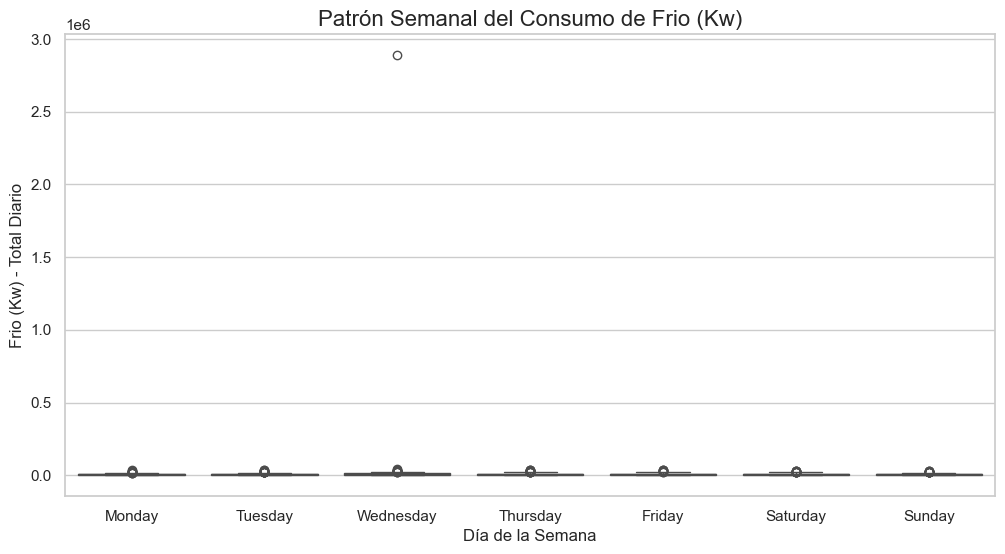

In [ ]:
# Gráfico Boxplot Semanal de 'Frio (Kw)'

if 'df_plot' in locals():
    plt.figure(figsize=(12, 6))

    # boxplot de Frio (Kw) agrupado por día de la semana
    sns.boxplot(data=df_plot, x='dia_semana', y='Frio (Kw)')

    plt.title('Patrón Semanal del Consumo de Frio (Kw)', fontsize=16)
    plt.xlabel('Día de la Semana')
    plt.ylabel('Frio (Kw) - Total Diario')
    plt.show()
else:
    print("El DataFrame 'df_plot' no existe.")